In [7]:
import qutip as qt
from functools import reduce
from pyscf import gto, scf

from scipy.optimize import minimize
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit.quantum_info import Statevector
import numpy as np



def initialize_state(state_vector : np.array) -> qt.tensor:

    # We define the basis of one qubit
    s_0 = qt.basis(2, 0)
    s_1 = qt.basis(2, 1)
    basis_states = [s_0, s_1]

    # We construct the quantum state as intended
    quantum_state = sum(
        state_vector[i] * qt.tensor(
            basis_states[(i >> 3) & 1],  # Qubit 1
            basis_states[(i >> 2) & 1],  # Qubit 2
            basis_states[(i >> 1) & 1],  # Qubit 3
            basis_states[(i >> 0) & 1]   # Qubit 4
        )
        for i in range(16)
    )

    # We normalize the state:
    quantum_state = quantum_state.unit()
    return quantum_state




def HF_Hamiltonian_Operator_qt(r_i : float) -> qt.Qobj:
    """
    This function returns the Hamiltonian operator of the H2
    molecule at a given distance r_i.

    args:
        r_i: distance between the two hydrogen atoms
    """

    driver = PySCFDriver(atom=f"F 0 0 0; H 0 0 {r_i}", basis="sto-3g")

    full_problem = driver.run()

    act_space_tf = ActiveSpaceTransformer(num_electrons= 2, num_spatial_orbitals= 2)

    problem = act_space_tf.transform(full_problem)
    hamiltonian = problem.hamiltonian.second_q_op()
    num_spin_orbitals = problem.num_spatial_orbitals
    identity_op = FermionicOp.one()

    # Escalar el operador identidad por la energía nuclear
    nuclear_energy_op = problem.nuclear_repulsion_energy * identity_op
    AST_energy_op = problem.hamiltonian.constants['ActiveSpaceTransformer']*identity_op
    hamiltonian_without_nuclear = hamiltonian + nuclear_energy_op + AST_energy_op

    mapper = JordanWignerMapper()

    init_state = HartreeFock(problem.num_spatial_orbitals,
                         problem.num_particles,
                         mapper)

    ansatz = UCCSD(problem.num_spatial_orbitals,
               problem.num_particles,
               mapper,
               initial_state= init_state)



    pauli_hamiltonian_op = mapper.map(hamiltonian_without_nuclear)

    matrix_representation = pauli_hamiltonian_op.to_matrix()
    qt_hamiltonian_op = qt.Qobj(matrix_representation, dims=[[2,2,2,2], [2,2,2,2]])

    return qt_hamiltonian_op, ansatz



def qutip_UCCSD_ansatz(uccsd, params):

    pauli_list = uccsd.operators
    init_state = Statevector(uccsd.initial_state).data

    init_qt_state = initialize_state(init_state)

    pauli_matrices = [ P_i.to_matrix() for P_i, t_i in zip(pauli_list, params) ]
    qt_pauli_objects = [ -1j * t_i * qt.Qobj(P_i, dims=[[2,2,2,2], [2,2,2,2]]) for P_i, t_i in zip(pauli_matrices, params) ]
    cluster_operators = [ P_i.expm() for P_i in qt_pauli_objects ]

    final_state = reduce(lambda state, U: U * state, cluster_operators, init_qt_state)

    return final_state



def cost_func_hf_uccsd(params_vec : np.array, *args):

    """
    Function to optimize: we will be optimizing the set of parameters of the Unitary.

    Args:
        params_vec: array of parameters for the Unitary.
        Hamiltonian: Hamiltonian operator of the system.
        state_vector: initial state of the system.
        N: number of qubits in the system.

    Returns:
        float: Expectation value of the Hamiltonian for the given state and parameters.
    """

    Hamiltonian = args[0]
    #state_vector = args[1]
    uccsd_circuit_ansatz = args[2]
    
    ansatz = qutip_UCCSD_ansatz(uccsd_circuit_ansatz, params_vec)

    return qt.expect(Hamiltonian, ansatz)



In [8]:

from qiskit.quantum_info import Statevector as SV

dataset_classes = {
    'C1' : SV.from_label('0000').data,
    'C3' : SV.from_label('0000').data + SV.from_label('1010').data,
    'C9' : SV.from_label('0000').data + SV.from_label('0101').data + SV.from_label('1010').data + SV.from_label('1111').data,
    'C11' : SV.from_label('0010') + SV.from_label('0100') + SV.from_label('1000'),
    'C15' : SV.from_label('0000').data + SV.from_label('1110').data,
    'C19' : SV.from_label('1000').data + SV.from_label('0100').data + SV.from_label('0010').data + SV.from_label('0001').data,
    'C26' : SV.from_label('0000').data + SV.from_label('1111').data,
    'C48' : SV.from_label('0000').data + SV.from_label('0011').data + SV.from_label('0101').data + SV.from_label('0110').data + SV.from_label('1000').data - SV.from_label('1011').data + SV.from_label('1101').data - SV.from_label('1110').data

}

final_dataset = {key : state / np.linalg.norm(state) for key, state in dataset_classes.items()}
availiable_classes = [key for key in final_dataset.keys()]
try_initial_psi_class = dataset_classes['C1']

In [9]:

distances = np.arange(0.5, 2.5, 0.05)
# Definir los límites de los parámetros de manera más eficiente

energies_uccsd_qt = np.zeros(len(distances))
energies_real_hf = np.zeros(len(distances))


bounds = [(0, np.pi) if i % 3 == 0 else (0, 2 * np.pi) for i in range(12)]


for j, rj in enumerate(distances):
  qt_HF_hamiltonian, uccsd_hf_ansatz = HF_Hamiltonian_Operator_qt(rj)
  energies_real_hf[j] = qt_HF_hamiltonian.eigenenergies()[0]

  num_opt_params = uccsd_hf_ansatz.num_parameters

  #bounds = [(0, np.pi) if i % 3 == 0 else (0, 2 * np.pi) for i in range(num_opt_params)]


    # Inicialización de los parámetros aleatorios dentro de los límites
  init_params_vec = np.array([np.random.uniform(-10, 10) for _ in range(num_opt_params)])

  # Argumentos de la función de costo
  
  args1 = (qt_HF_hamiltonian, try_initial_psi_class, uccsd_hf_ansatz)  # Estado de la clase de entrelazamiento, Hamiltoniano de la molécula

        # Minimización usando COBYLA
  VQE = minimize(cost_func_hf_uccsd, init_params_vec, args=args1,
              method='COBYLA',
              options={'maxiter': 1500, 'disp': True})

  energies_uccsd_qt[j] = VQE.fun




   Normal return from subroutine COBYLA

   NFVALS =   63   F =-9.770843E+01    MAXCV = 0.000000E+00
   X =-9.424667E+00  -3.141555E+00   3.126202E+00

   Normal return from subroutine COBYLA

   NFVALS =   53   F =-9.799594E+01    MAXCV = 0.000000E+00
   X =-7.853945E+00   7.853992E+00   7.838054E+00

   Normal return from subroutine COBYLA

   NFVALS =   73   F =-9.819437E+01    MAXCV = 0.000000E+00
   X =-3.141585E+00  -3.141488E+00   3.124805E+00

   Normal return from subroutine COBYLA

   NFVALS =   54   F =-9.833130E+01    MAXCV = 0.000000E+00
   X =-4.712459E+00  -7.853911E+00  -7.871636E+00

   Normal return from subroutine COBYLA

   NFVALS =   72   F =-9.842526E+01    MAXCV = 0.000000E+00
   X =-6.283161E+00   3.141583E+00  -9.443217E+00

   Normal return from subroutine COBYLA

   NFVALS =   51   F =-9.848876E+01    MAXCV = 0.000000E+00
   X = 4.712308E+00  -1.570770E+00   7.834313E+00

   Normal return from subroutine COBYLA

   NFVALS =   52   F =-9.853030E+01    MAXCV =

/tmp/ipykernel_27316/530567696.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(availiable_classes))


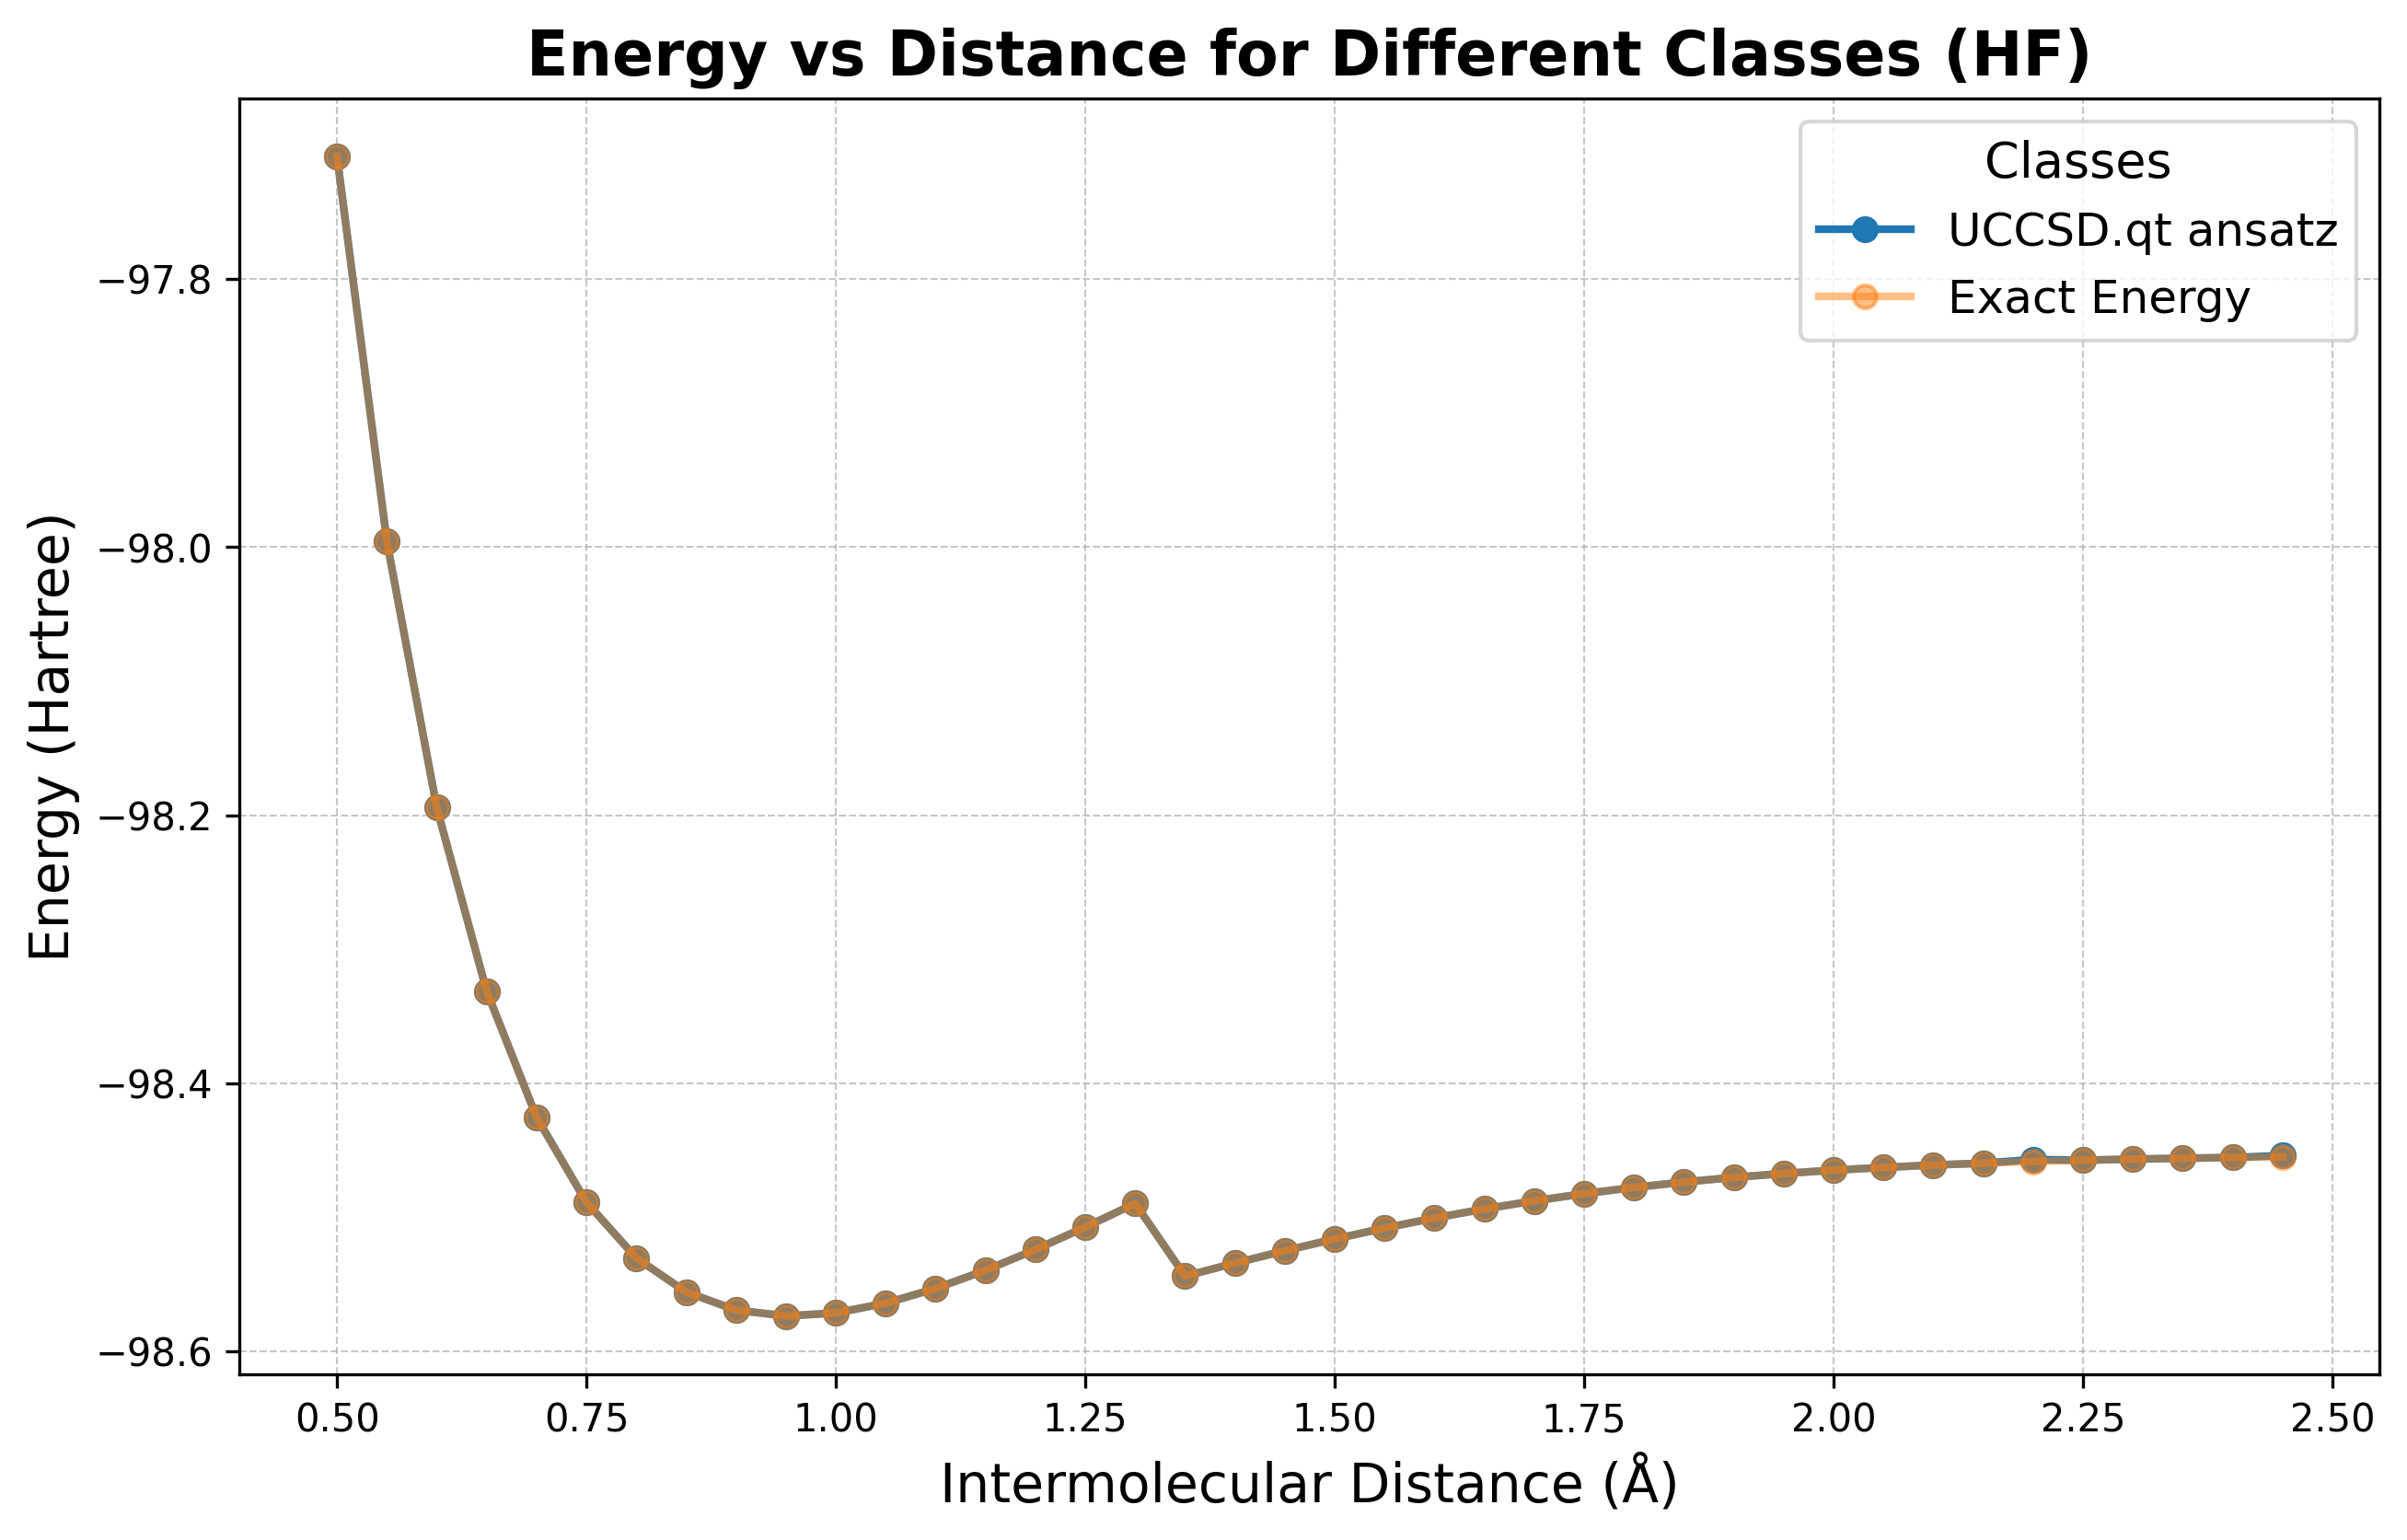

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Create a color map (Viridis) with as many colors as the number of classes
cmap = cm.get_cmap('viridis', len(availiable_classes))


plt.figure(figsize=(10, 6), dpi=300)  # High-quality figure

# Loop over each class and assign colors from the Viridis colormap


plt.plot(distances, energies_uccsd_qt, 'o-', label='UCCSD.qt ansatz', linewidth=2, markersize=6)
plt.plot(distances, energies_real_hf, 'o-', label='Exact Energy', linewidth=2, markersize=6 , alpha= 0.5)



# Labels, title, and styles
plt.xlabel('Intermolecular Distance (Å)', fontsize=14)
plt.ylabel('Energy (Hartree)', fontsize=14)
plt.title('Energy vs Distance for Different Classes (HF)', fontsize=16, fontweight='bold')

#Esto es para hacer zoom automatico
#plt.xlim((0.3, 1))


# Aesthetic improvements
plt.legend(title='Classes', fontsize=12, title_fontsize=13, loc='best', frameon=True)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Show the plot
plt.show()